# Stain Deconvolution and Color Normalization

[![View on GitHub](https://img.shields.io/badge/View-on%20GitHub-lightgrey?logo=github)](https://github.com/Dana-Farber-AIOS/pathml/blob/master/examples/stain_normalization.ipynb)

This notebook gives examples of the stain deconvolution and color normalization tools available in `PathML`.

H&E images are the result of applying two stains to a tissue sample: hematoxylin and eosin.
The hematoxylin binds to the cell nuclei and colors them purple, while the eosin binds to the cytoplasm and extracellular matrix, coloring them pink. Stain deconvolution is the process of untangling these two superimposed stains from an H&E image.

Digital pathology images can vary for many reasons, including:

- variation in stain intensity due to inconsistencies of technicians while applying stains to specimens
- variation in image qualities due to differences in slide scanners
- variation due to differences in lighting conditions when slide is scanned
- etc.

For these reasons, color normalization is a crucial part of any computational pathology workflow.

Stain deconvolution can also be used in other ways, due to the different biological properties of the stains. For example, we can apply stain separation and use the hematoxylin channel as input to a nucleus detection algorithm (see nucleus detection example notebook).

`PathML` comes with two stain deconvolution algorithms out of the box: the Macenko and Vahadane methods (Macenko et al. 2009; Vahadane et al. 2016). As more stain deconvolution methods are incorporated into `PathML`, they will be added here.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from pathml.core import HESlide
from pathml.preprocessing import StainNormalizationHE

In [3]:
fontsize = 20

**OpenSlide Data**

This example notebook uses publicly available images from OpenSlide. Download them [here](http://openslide.cs.cmu.edu/download/openslide-testdata/Aperio/) if you want to run this notebook locally, or change the filepaths to any whole-slide images that you have locally.

We will pull out a 500px tile to use as an example:

In [4]:
wsi = HESlide("../data/CMU-1-Small-Region.svs")
region = wsi.slide.extract_region(location = (900, 800), size = (500, 500))

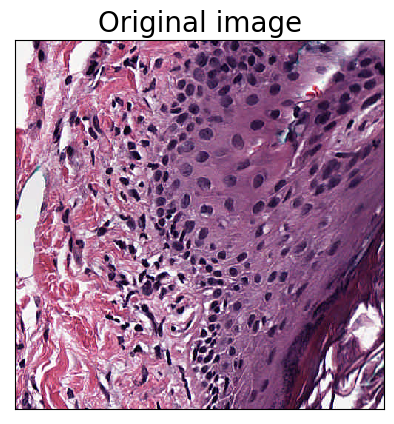

In [5]:
plt.imshow(region)
plt.title('Original image', fontsize=fontsize)
plt.gca().set_xticks([])
plt.gca().set_yticks([])
plt.show()

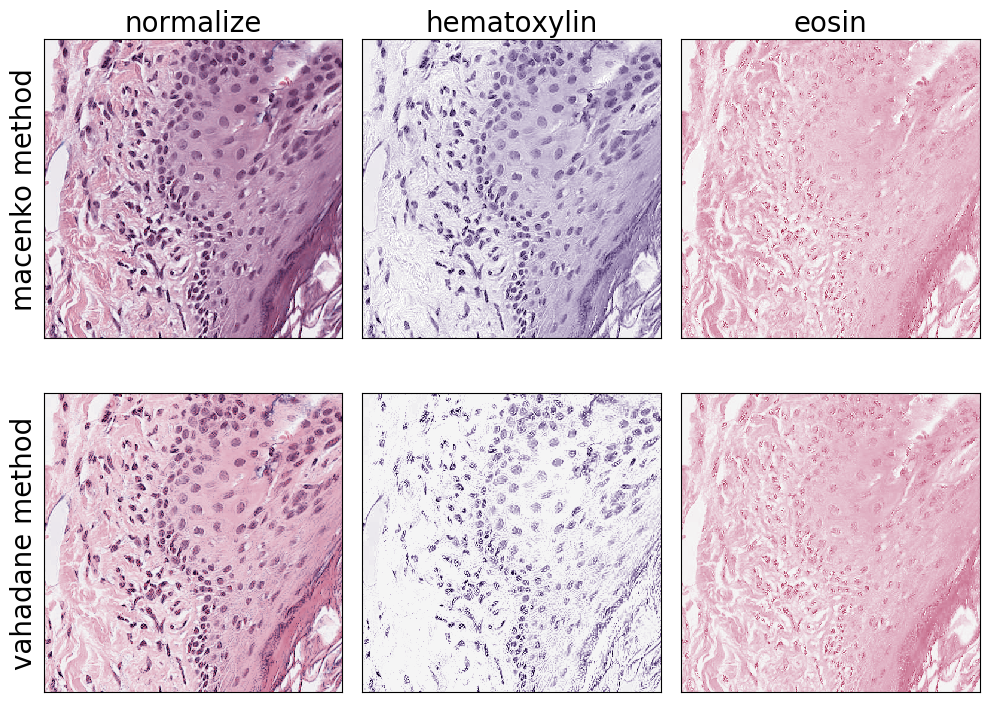

In [6]:
fig, axarr = plt.subplots(nrows=2, ncols=3, figsize=(10, 7.5))

for i, method in enumerate(["macenko", "vahadane"]):
    for j, target in enumerate(["normalize", "hematoxylin", "eosin"]):
        # initialize stain normalization object
        normalizer = StainNormalizationHE(target = target, stain_estimation_method = method)
        # apply on example image
        im = normalizer.F(region)
        # plot results
        ax = axarr[i, j]
        ax.imshow(im)
        if j == 0:
            ax.set_ylabel(f"{method} method", fontsize=fontsize)
        if i == 0:
            ax.set_title(target, fontsize = fontsize)
                
for a in axarr.ravel():
    a.set_xticks([])
    a.set_yticks([])

plt.tight_layout()
plt.show()

## References

* Macenko, M., Niethammer, M., Marron, J.S., Borland, D., Woosley, J.T., Guan, X., Schmitt, C. and Thomas, N.E., 2009, June. A method for normalizing histology slides for quantitative analysis. In 2009 IEEE International Symposium on Biomedical Imaging: From Nano to Macro (pp. 1107-1110). IEEE.
* Vahadane, A., Peng, T., Sethi, A., Albarqouni, S., Wang, L., Baust, M., Steiger, K., Schlitter, A.M., Esposito, I. and Navab, N., 2016. Structure-preserving color normalization and sparse stain separation for histological images. IEEE transactions on medical imaging, 35(8), pp.1962-1971.